In [47]:
'''
Vignette for OASIS (https://www.pnas.org/doi/10.1073/pnas.2304671121)
Tavor Z. Baharav, David Tse, and Julia Salzman

OASIS (Optimized Adaptive Statistic for Inferring Structure) utilizes a linear test-statistic, enabling the computation of closed form P-value bounds, exact asymptotic ones, and interpretable rejection of the null.
Key method is OASIS_pvalue. Documentation at https://oasis-stat.readthedocs.io/en/latest/. 
OASIS is used in SPLASH: https://github.com/refresh-bio/SPLASH, a method for reference-free genomic inference.

Please reach out on github with any questions, or directly to tavorb@mit.edu.
'''


'\nVignette for OASIS (https://www.pnas.org/doi/10.1073/pnas.2304671121)\nTavor Z. Baharav, David Tse, and Julia Salzman\n\nOASIS (Optimized Adaptive Statistic for Inferring Structure) utilizes a linear test-statistic, enabling the computation of closed form P-value bounds, exact asymptotic ones, and interpretable rejection of the null.\nKey method is OASIS_pvalue. Documentation at https://oasis-stat.readthedocs.io/en/latest/. \nOASIS is used in SPLASH: https://github.com/refresh-bio/SPLASH, a method for reference-free genomic inference.\n\nPlease reach out on github with any questions, or directly to tavorb@mit.edu.\n'

In [8]:
import numpy as np
import scipy.stats
from src.oasis_stat import *
import matplotlib.pyplot as plt


In [4]:
### list of all functions
oasis_stat.splitCountsColwise
oasis_stat.generate_cf_finite_optimized
oasis_stat.generate_cf_asymp_optimized
oasis_stat.compute_test_stat
oasis_stat.compute_pvalue
oasis_stat.effectSize_bin
oasis_stat.OASIS_pvalue

<function src.oasis_stat.oasis_stat.OASIS_pvalue(X, numSplits=5, trainFrac=0.25, asymptotic=False, return_f_c=False, return_test_stat=False, return_effect_size=False, random_seed=0)>

In [52]:
######## simulate the null, showing that OASIS's asymptotic P-value is indeed uniformly distributed under the null (even for 10 counts per column)
I=10
J=20
np.random.seed(0)
p= np.random.dirichlet(np.ones(I))
ctsPerCol = 10
c = np.random.uniform(-1,1,J)
c/= np.linalg.norm(c)
f = np.random.choice([-1,1],I)*1.0

num_trials = 1000

pvalArr = np.zeros(num_trials)

for i in range(num_trials):
    np.random.seed(i)
    X = np.zeros((I,J))

    for j in range(J):
        X[:,j] = np.random.multinomial(ctsPerCol,p)


    pval, f, c, test_stat, effect_size = oasis_stat.OASIS_pvalue(X, return_f_c=True, asymptotic=True, return_test_stat=True, return_effect_size=True, numSplits=1, trainFrac=.1)
    pvalArr[i] = pval

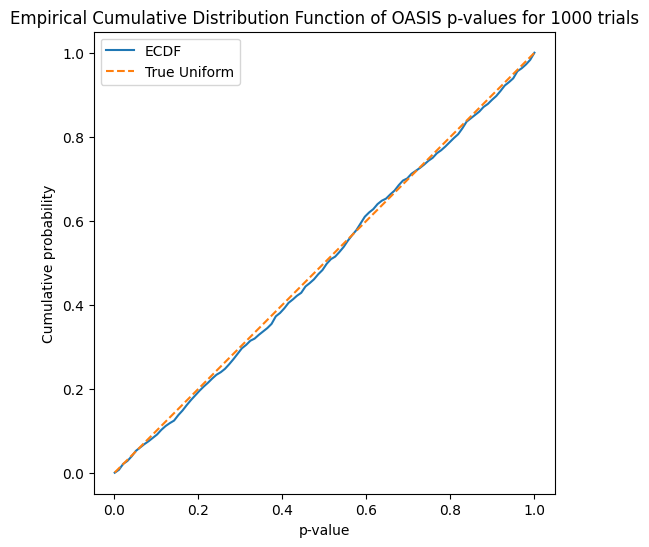

In [53]:

plt.figure(figsize=(6, 6))  # Set the figure size to create a square plot
plt.plot(x, y, label='ECDF')
plt.plot(x, x, label='True Uniform', linestyle='--')
plt.xlabel('p-value')
plt.ylabel(f'Cumulative probability')
plt.title(f'Empirical Cumulative Distribution Function of OASIS p-values for {num_trials} trials')
plt.legend()
plt.gca().set_aspect('equal')  # Set the aspect ratio to be equal
plt.show()


In [54]:
######## generate planted signal example
I=6
J=10
np.random.seed(0)
plantedGroups = (np.arange(J)>=J//2)*2-1


p1 = np.random.dirichlet(np.ones(I)*2)
p2 = np.random.dirichlet(np.ones(I)*2)
n = np.random.poisson(40, size=J)

X = np.zeros((I,J))
for j in range(J):
    if plantedGroups[j]==-1:
        X[:,j] = np.random.multinomial(n[j],p1)
    else:
        X[:,j] = np.random.multinomial(n[j],p2)
        
        
pval,fOpt,cOpt = OASIS_pvalue(X, numSplits=10, return_f_c=True)
# plt.imshow(X)

OASIS finite-sample p-value: 4.56441509170271e-10


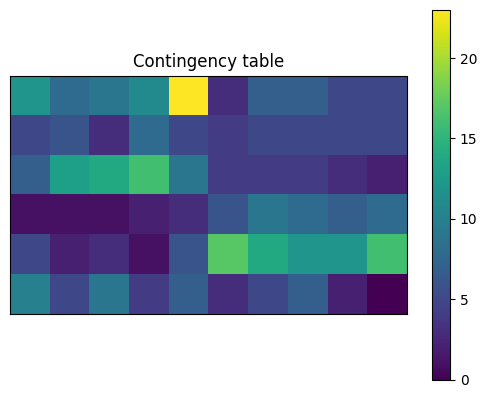

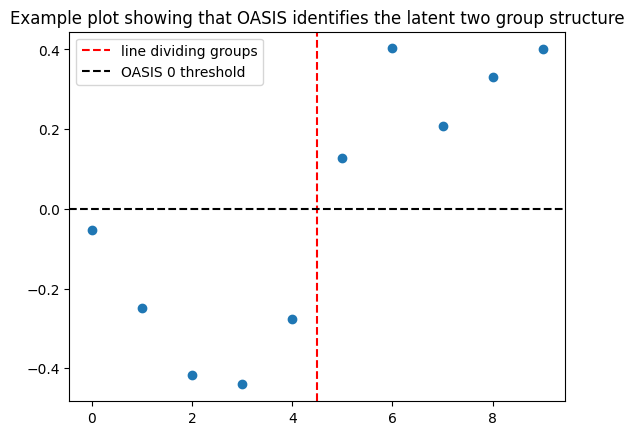

In [55]:
print('OASIS finite-sample p-value:',pval)
plt.imshow(X)
plt.xticks([])
plt.yticks([])
plt.title('Contingency table')
plt.colorbar()

plt.figure()
plt.scatter(np.arange(J),cOpt)
plt.title('Example plot showing that OASIS identifies the latent two group structure')
plt.axvline(J//2-.5, color='r', linestyle='--', label='line dividing groups')
plt.axhline(0, color='black', linestyle='--', label='OASIS 0 threshold')
plt.legend()

In [56]:
### Example with two groups, showing that OASIS's effect size tracks the tv distance between the two latent groups in this simple setting



num_outer_loops = 10
num_inner_loops = 100
I = 6
J = 20
num_splits = 5
np.random.seed(0)

effect_size_arr = np.zeros((num_outer_loops,num_inner_loops))
tv_distance_arr = np.zeros(num_outer_loops)

for i in range(num_outer_loops):
    np.random.seed(i)
    p1 = np.random.dirichlet(np.ones(I)/(i+1)*4) ### to get different distributions across i
    p2 = np.random.dirichlet(np.ones(I)/(i+1)*4)
    n = np.random.poisson(40, size=J)
    plantedGroups = (np.arange(J)>=J//2)*2-1

    tv_distance_arr[i] = np.sum(np.abs(p1-p2))/2

    for j in range(num_inner_loops):
        np.random.seed(j)
        X = np.zeros((I,J))
        for k in range(J):
            if plantedGroups[k]==-1:
                X[:,k] = np.random.multinomial(n[k],p1)
            else:
                X[:,k] = np.random.multinomial(n[k],p2)

        pval,fOpt,cOpt, effect_size= OASIS_pvalue(X, numSplits=num_splits, return_f_c=True,return_effect_size=True)
        effect_size_arr[i,j] = effect_size

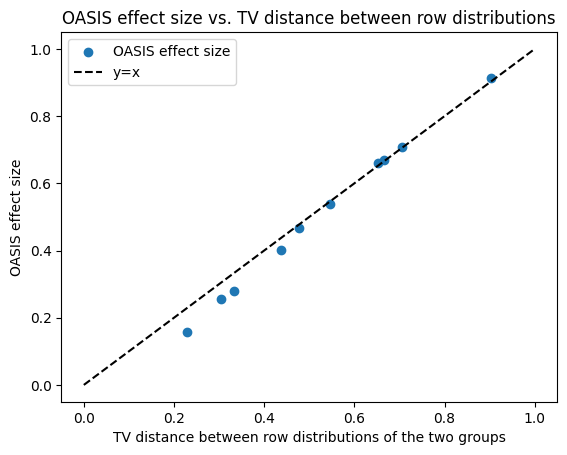

In [57]:
### plot results
plt.figure()
plt.scatter(tv_distance_arr,np.mean(effect_size_arr,axis=1),label='OASIS effect size')
plt.plot([0,1],[0,1],label='y=x',linestyle='--', color='black')
plt.xlabel('TV distance between row distributions of the two groups')
plt.ylabel('OASIS effect size')
plt.title('OASIS effect size vs. TV distance between row distributions')
plt.legend()
